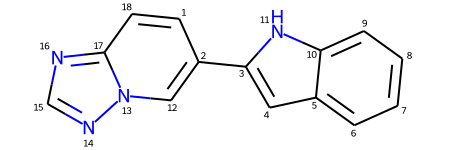

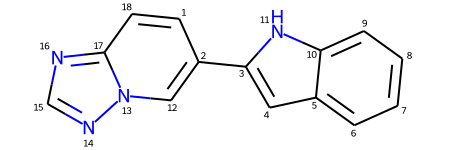

In [33]:
'''  Show the structure  '''
from rdkit import Chem
from utils.common_utils import get_mol,mol_with_atom_index
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display, SVG, display_svg

smi="c1c(c2cc(cccc3)c3[nH]2)cn4ncnc4c1"
mol=get_mol(smi)
mol=mol_with_atom_index(mol)
display(mol)

smi="c1c(c2cc(cccc3)c3[nH]2)cn4ncnc4c1"
mol=get_mol(smi)
mol=mol_with_atom_index(mol)
display(mol)

In [ ]:
'''  Compare the structure and plot (Two sites) '''
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem,Draw
from rdkit.Chem import MCS
import pandas as pd
import numpy as np
import copy,re
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol,MakeScaffoldGeneric,MurckoScaffoldSmiles,MurckoScaffoldSmilesFromSmiles
# from my_toolset.my_utils import get_mol,compute_FP,canonic_smiles,mapper
from utils.common_utils import mapper,csvToExcel,get_mol,compute_FP,canonic_smiles,float_row,heavy_atm_smiles,kekulize_smi
from utils.sarm_utils import get_core
import os,sys
from IPython.display import display, SVG, display_svg
import seaborn as sns
from matplotlib import pyplot
from pathlib import Path
# pyplot.figure(figsize=(30, 15))
csv2excel=True  ## Transform the csv file into excel
if not csv2excel:
    def csvToExcel(*args1,**args2):
        pass

work_dir="ComparePlot/Feb14/CoreA"

# R_position=1             
# sub_structures=["[C,F,Cl]c1ccn2ncnc2c1","n1(ncn2)c2c[c;H1]cc1"] 
# R_position=2                
# sub_structures=["[C,F,Cl]c1c(ncn2)n2ccc1","n1(ncn2)c2[c;H1]ccc1"] 
# R_position=3                
# sub_structures=["[C,F,Cl]c1nc(cccc2)n2n1","n1(n[c;H1]n2)c2cccc1"] 
# R_position=4               
# sub_structures=["[C,F,Cl]c1n2ncnc2ccc1","n1(ncn2)c2ccc[c;H1]1"] 

# sub_structures=["[*;!$([CX3]=[OX1])]N(CC1)CCC1c2cc(cc[nH]3)c3cc2","O=C([*])N(CC1)CCC1c2cc(cc[nH]3)c3cc2"] 
# sub_structures=["[!$(C=O)]N(CC1)CCC1c2cc(cc[nH]3)c3cc2","O=C([*])N(CC1)CCC1c2cc(cc[nH]3)c3cc2"] 

sub_structures=["C12=N[CH]=NN1[CH]=C(C3=CC4C(C=CN4)C=C3)[CX4;!$([CH])]=[CH]2","C12=N[CH]=NN1[CH]=C(C3=CC4C(C=CN4)C=C3)[CH]=[CH]2"] 
R_position='R1' 
note=sub_structures[0]

work_path=Path(work_dir)
work_path.mkdir(exist_ok=True, parents=True)
df_act=pd.read_csv("/public/home/zhangjie/Project_support/AIXB-5/Selectivity_Jan16/MedChemAct_Cano_Sele_JAN16.csv")
df_act=float_row(df_act, cols=["TLR8to7","Affinity_TLR7","Affinity_TLR8"])
df_act=df_act.dropna(subset=["TLR8to7","Affinity_TLR7","Affinity_TLR8"])
for irow in ["TLR8to7","Affinity_TLR7","Affinity_TLR8"]:
    df_act[irow]=df_act[irow].apply(np.log10)
df_act=df_act.replace(-np.inf, np.nan)
df_act=df_act.dropna(subset=["TLR8to7","Affinity_TLR7","Affinity_TLR8"])
df_act['index']=df_act['Cano_SMILES'] 
df_act=df_act.set_index("index")

matched_list=[[] for ismarts in sub_structures]
for irow,row in df_act.iterrows():
    # print(ismi)
    ismi=row['Cano_SMILES']
    imol=Chem.MolFromSmiles(ismi)
    if imol==None: continue
    for idx,ismarts in enumerate(sub_structures):
        ismarts_mol=Chem.MolFromSmarts(ismarts)
        matched=imol.GetSubstructMatches(ismarts_mol)
        if len(matched)>0:
            matched_list[idx].append(irow)
            # print(f"Matched: {irow}")
re_p=re.compile(r'\[(((?!nH).)*?)\]')          
df_res=pd.DataFrame.from_dict({'Value':[],'Type':[],'Group':[], 'R-Group':[], 'Cano_SMILES':[], 'R_heavyAtm_count':[]})
for idx,imatch in enumerate(matched_list):
    df_act.loc[imatch,'Group']=f"Group{idx}"
    df_act.loc[imatch,'Group_SMARTS']=sub_structures[idx]
    df_grp_tmp=df_act.loc[imatch]
    ismart_smi = re.sub(re_p, '*', sub_structures[idx]) 
    ismart_mol=Chem.MolFromSmarts(ismart_smi)
    ismart_mol_atoms=ismart_mol.GetAtoms()
    ismart_dummies=ismart_mol.GetSubstructMatches(Chem.MolFromSmarts('[#0]'))
    idummy_neighs=ismart_mol_atoms[ismart_dummies[0][0]].GetNeighbors()
    if len(idummy_neighs) == 1:
        R_frags=[]   ## SMILES of the R group fragment
        heavy_atm_counts=[]   ## Count of heavy atoms in the R group
        smis=[]   ## Count of heavy atoms in the R group
        
        for jdx,jrow in df_grp_tmp.iterrows():
            jsmi=jrow['Cano_SMILES']
            jsmarts = re.sub(re_p, '*', sub_structures[idx]) 
            try:
            # if 1:
                jfrag_complete = get_core(jsmi, [jsmarts])
                heavy_atm_count=heavy_atm_smiles(jfrag_complete)
                # print("jfrag_complete= ", jfrag_complete)
            except Exception as e:
                print(e)
                jfrag_complete=''
                heavy_atm_count=0
            R_frags.append(jfrag_complete)
            heavy_atm_counts.append(heavy_atm_count)
            smis.append(kekulize_smi(jsmi))
        # print("R_frags",R_frags)
    else:
        R_frags=['' for ii in range(len(df_grp_tmp))]
        heavy_atm_counts=[0 for ii in range(len(df_grp_tmp))]
        smis=[kekulize_smi(ismi) for ismi in df_grp_tmp['Cano_SMILES']]
    df_grp_tmp=pd.DataFrame(df_grp_tmp)  
    df_grp_tmp['R_frags']=R_frags
    df_grp_tmp['heavy_atm_counts']=heavy_atm_counts    
    df_tmp=pd.DataFrame.from_dict({'Value':df_grp_tmp['Affinity_TLR7'], 'Type':['Affinity_TLR7' for i in df_grp_tmp.index],  'Group':df_grp_tmp['Group'], 'R-Group':R_frags, 'Cano_SMILES':smis, 'R_heavyAtm_count':heavy_atm_counts})
    df_res=df_res.append(df_tmp)
    df_tmp=pd.DataFrame.from_dict({'Value':df_grp_tmp['Affinity_TLR8'], 'Type':['Affinity_TLR8' for i in df_grp_tmp.index],  'Group':df_grp_tmp['Group'], 'R-Group':R_frags, 'Cano_SMILES':smis, 'R_heavyAtm_count':heavy_atm_counts})
    df_res=df_res.append(df_tmp)
    df_tmp=pd.DataFrame.from_dict({'Value':df_grp_tmp['TLR8to7'], 'Type':['Affinity_8to7' for i in df_grp_tmp.index],  'Group':df_grp_tmp['Group'],  'R-Group':R_frags, 'Cano_SMILES':smis, 'R_heavyAtm_count':heavy_atm_counts})
    df_res=df_res.append(df_tmp)
    
    ''' Plot 2D distribution '''
    df_sns=pd.DataFrame(df_res[df_res['Group']==f"Group{idx}"])
    df_sns['id']=range(len(df_sns))
    df_sns=df_sns.set_index('id')
    df_sele_index=df_sns[df_sns['Type']=='Affinity_TLR7'].index
    df_sns.loc[df_sele_index,'R_heavyAtm_count']=df_sns.loc[df_sele_index, 'R_heavyAtm_count']-0.25+np.random.uniform(0, 0.1, size=len(df_sele_index))
    df_sele_index=df_sns[df_sns['Type']=='Affinity_TLR8'].index
    df_sns.loc[df_sele_index,'R_heavyAtm_count']=df_sns.loc[df_sele_index, 'R_heavyAtm_count']-0.05+np.random.uniform(0, 0.1, size=len(df_sele_index))
    df_sele_index=df_sns[df_sns['Type']=='Affinity_8to7'].index
    df_sns.loc[df_sele_index,'R_heavyAtm_count']=df_sns.loc[df_sele_index, 'R_heavyAtm_count']+0.15+np.random.uniform(0, 0.1, size=len(df_sele_index))
    
    # fig=pyplot.figure()
    fig, ax = pyplot.subplots()
    sns.scatterplot(
    data=df_sns, x="R_heavyAtm_count", y="Value", hue="Type", alpha=0.4
    )
    pyplot.title(f"Group{idx}")
    pyplot.ylabel(f"Value (log)")
    # ax.set_yscale('log')
    fig.savefig(work_path.joinpath(f'Figure_Group{idx}_Position{R_position}_{note}.jpg'),dpi=300)
    for irow in ["TLR8to7","Affinity_TLR7","Affinity_TLR8"]:
        df_grp_tmp[irow]=df_grp_tmp[irow].apply(lambda x:np.power(10, x))
        df_grp_tmp[irow]=df_grp_tmp[irow].round(1)
    df_grp_tmp.to_csv(work_path.joinpath(f"OrgData_Group{idx}_Position{R_position}_{note}.csv"), index=None)  
    csvToExcel(work_path.joinpath(f"OrgData_Group{idx}_Position{R_position}_{note}.csv"), imgCols=['SMILES','R_frags'],save_file=work_path.joinpath(f"OrgData_Group{idx}_Position{R_position}_{note}.xlsx"))

df_res.to_csv(work_path.joinpath(f"Figure_Data_Position{R_position}_{note}.csv"), index=None)  
# csvToExcel(work_path.joinpath(f"Figure_Data_Position{R_position}_{note}.csv"), imgCols=['Key2'],save_file=work_path.joinpath(f"Figure_Data_Position{R_position}_{note}.xlsx"))
g=sns.catplot(data=df_res, x="Type", y="Value", hue="Group",
    kind="violin", split=True)
pyplot.ylabel(f"Value (log)")
g.savefig(work_path.joinpath(f'Figure_distrb_Position{R_position}_{note}.jpg'),dpi=300)


Matched count group 0: 1; group 1: 289;
local variable 'R_atom' referenced before assignment
local variable 'R_atom' referenced before assignment
local variable 'R_atom' referenced before assignment
local variable 'R_atom' referenced before assignment
local variable 'R_atom' referenced before assignment
local variable 'R_atom' referenced before assignment
local variable 'R_atom' referenced before assignment
local variable 'R_atom' referenced before assignment
local variable 'R_atom' referenced before assignment
local variable 'R_atom' referenced before assignment
local variable 'R_atom' referenced before assignment
local variable 'R_atom' referenced before assignment
local variable 'R_atom' referenced before assignment
local variable 'R_atom' referenced before assignment
local variable 'R_atom' referenced before assignment
local variable 'R_atom' referenced before assignment
local variable 'R_atom' referenced before assignment
local variable 'R_atom' referenced before assignment
local 

/public/home/zhangjie/anaconda3/envs/reinvent1/lib/python3.7/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/public/home/zhangjie/anaconda3/envs/reinvent1/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/public/home/zhangjie/anaconda3/envs/reinvent1/lib/python3.7/site-packages/seaborn/axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):


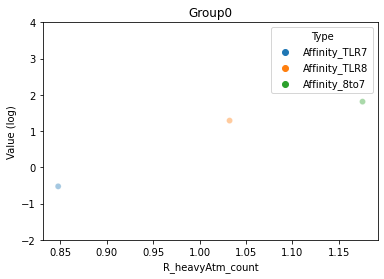

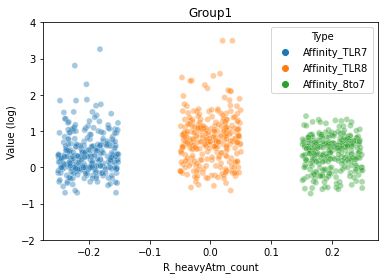

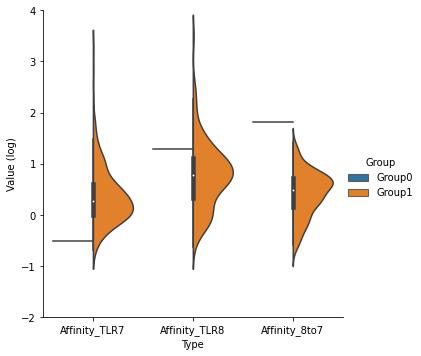

In [30]:
'''  Compare the structure and plot (Multiple sites) '''
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem,Draw
from rdkit.Chem import MCS
import pandas as pd
import numpy as np
import copy,re
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol,MakeScaffoldGeneric,MurckoScaffoldSmiles,MurckoScaffoldSmilesFromSmiles
# from my_toolset.my_utils import get_mol,compute_FP,canonic_smiles,mapper
from utils.common_utils import mapper,csvToExcel,get_mol,compute_FP,canonic_smiles,float_row,heavy_atm_smiles,kekulize_smi
from utils.sarm_utils import get_core,get_single_frag
import os,sys
from IPython.display import display, SVG, display_svg
import seaborn as sns
from matplotlib import pyplot
from pathlib import Path
# pyplot.figure(figsize=(30, 15))
csv2excel=True  ## Transform the csv file into excel
if not csv2excel:
    def csvToExcel(*args1,**args2):
        pass

work_dir="ComparePlot/Feb14/CoreA"

# sub_structures=["[*;cX3;H0]1c(c2cc(cccc3)c3[nH]2)[cH]n4n[cX3;H0]nc4[cX3;H0]1","[*;cH]1c(c2cc(cccc3)c3[nH]2)[cH]n4n[cX3;H0]nc4[cX3;H0]1"] 
# R_position='R2R3T-R1' 

# sub_structures=["[cX3;H0]1c(c2cc(cccc3)c3[nH]2)[cH]n4n[cX3;H0]nc4[*;cX3;H0]1","[cX3;H0]1c(c2cc(cccc3)c3[nH]2)[cH]n4n[cX3;H0]nc4[*;cH]1"] 
# R_position='R1R3T-R2' 

sub_structures=["[cX3;H0]1c(c2cc(cccc3)c3[nH]2)[cH]n4n[*;cX3;H0]nc4[cX3;H0]1","[cX3;H0]1c(c2cc(cccc3)c3[nH]2)[cH]n4n[*;cH]nc4[cX3;H0]1"] 
R_position='R1R2-R3' 

# sub_structures=["[cH]1c(c2cc(cccc3)c3[nH]2)[*;cX3;H0]n4n[cH]nc4[cH]1","[cH]1c(c2cc(cccc3)c3[nH]2)[*;cH]n4n[cH]nc4[cH]1"] 
# R_position='R4_single' 



note=sub_structures[0]

work_path=Path(work_dir)
work_path=work_path.joinpath(R_position)
work_path.mkdir(exist_ok=True, parents=True)
df_act=pd.read_csv("/public/home/zhangjie/Project_support/AIXB-5/Selectivity_Jan16/MedChemAct_Cano_Sele_JAN16.csv")
df_act=float_row(df_act, cols=["TLR8to7","Affinity_TLR7","Affinity_TLR8"])
df_act=df_act.dropna(subset=["TLR8to7","Affinity_TLR7","Affinity_TLR8"])
for irow in ["TLR8to7","Affinity_TLR7","Affinity_TLR8"]:
    df_act[irow]=df_act[irow].apply(np.log10)
df_act=df_act.replace(-np.inf, np.nan)
df_act=df_act.dropna(subset=["TLR8to7","Affinity_TLR7","Affinity_TLR8"])
df_act['index']=df_act['Cano_SMILES'] 
df_act=df_act.set_index("index")

matched_list=[[] for ismarts in sub_structures]
for irow,row in df_act.iterrows():
    # print(ismi)
    ismi=row['Cano_SMILES']
    imol=Chem.MolFromSmiles(ismi)
    if imol==None: continue
    for idx,ismarts in enumerate(sub_structures):
        ismarts_mol=Chem.MolFromSmarts(ismarts)
        matched=imol.GetSubstructMatches(ismarts_mol)
        if len(matched)>0:
            matched_list[idx].append(irow)
            # print(f"Matched: {irow}")
print(f"Matched count group 0: {len(matched_list[0])}; group 1: {len(matched_list[1])};")
re_p=re.compile(r'\[(\*((?!nH).)*?)\]')          
df_res=pd.DataFrame.from_dict({'Value':[],'Type':[],'Group':[], 'R-Group':[], 'Cano_SMILES':[], 'R_heavyAtm_count':[]})
for idx,imatch in enumerate(matched_list):
    df_act.loc[imatch,'Group']=f"Group{idx}"
    df_act.loc[imatch,'Group_SMARTS']=sub_structures[idx]
    df_grp_tmp=df_act.loc[imatch]
    # ismart_smi = re.sub(re_p, '*', sub_structures[idx]) 
    # print(f"{sub_structures[idx]} -> {ismart_smi}")
    # ismart_mol=Chem.MolFromSmarts(ismart_smi)
    # ismart_mol_atoms=ismart_mol.GetAtoms()
    # ismart_dummies=ismart_mol.GetSubstructMatches(Chem.MolFromSmarts('[#0]'))
    # idummy_neighs=ismart_mol_atoms[ismart_dummies[0][0]].GetNeighbors()
    # if len(idummy_neighs) == 1:
    R_frags=[]   ## SMILES of the R group fragment
    heavy_atm_counts=[]   ## Count of heavy atoms in the R group
    smis=[]   ## Count of heavy atoms in the R group
    
    for jdx,jrow in df_grp_tmp.iterrows():
        jsmi=jrow['Cano_SMILES']
        jsmarts=sub_structures[idx]
        # jsmarts = re.sub(re_p, '*', sub_structures[idx]) 
        try:
        # if 1:
            # jfrag_complete = get_core(jsmi, [jsmarts])
            jfrag_complete = get_single_frag(jsmi, jsmarts)
            heavy_atm_count = heavy_atm_smiles(jfrag_complete)
            # print("jfrag_complete= ", jfrag_complete)
        except Exception as e:
            print(e)
            jfrag_complete=''
            heavy_atm_count=0
        R_frags.append(jfrag_complete)
        heavy_atm_counts.append(heavy_atm_count)
        smis.append(kekulize_smi(jsmi))
        # print("R_frags",R_frags)
    # else:
    #     R_frags=['' for ii in range(len(df_grp_tmp))]
    #     heavy_atm_counts=[0 for ii in range(len(df_grp_tmp))]
    #     smis=[kekulize_smi(ismi) for ismi in df_grp_tmp['Cano_SMILES']]
    df_grp_tmp=pd.DataFrame(df_grp_tmp)  
    df_grp_tmp['R_frags']=R_frags
    df_grp_tmp['heavy_atm_counts']=heavy_atm_counts    
    df_tmp=pd.DataFrame.from_dict({'Value':df_grp_tmp['Affinity_TLR7'], 'Type':['Affinity_TLR7' for i in df_grp_tmp.index],  'Group':df_grp_tmp['Group'], 'R-Group':R_frags, 'Cano_SMILES':smis, 'R_heavyAtm_count':heavy_atm_counts})
    df_res=df_res.append(df_tmp)
    df_tmp=pd.DataFrame.from_dict({'Value':df_grp_tmp['Affinity_TLR8'], 'Type':['Affinity_TLR8' for i in df_grp_tmp.index],  'Group':df_grp_tmp['Group'], 'R-Group':R_frags, 'Cano_SMILES':smis, 'R_heavyAtm_count':heavy_atm_counts})
    df_res=df_res.append(df_tmp)
    df_tmp=pd.DataFrame.from_dict({'Value':df_grp_tmp['TLR8to7'], 'Type':['Affinity_8to7' for i in df_grp_tmp.index],  'Group':df_grp_tmp['Group'],  'R-Group':R_frags, 'Cano_SMILES':smis, 'R_heavyAtm_count':heavy_atm_counts})
    df_res=df_res.append(df_tmp)
    
    ''' Plot 2D distribution '''
    df_sns=pd.DataFrame(df_res[df_res['Group']==f"Group{idx}"])
    df_sns['id']=range(len(df_sns))
    df_sns=df_sns.set_index('id')
    df_sele_index=df_sns[df_sns['Type']=='Affinity_TLR7'].index
    df_sns.loc[df_sele_index,'R_heavyAtm_count']=df_sns.loc[df_sele_index, 'R_heavyAtm_count']-0.25+np.random.uniform(0, 0.1, size=len(df_sele_index))
    df_sele_index=df_sns[df_sns['Type']=='Affinity_TLR8'].index
    df_sns.loc[df_sele_index,'R_heavyAtm_count']=df_sns.loc[df_sele_index, 'R_heavyAtm_count']-0.05+np.random.uniform(0, 0.1, size=len(df_sele_index))
    df_sele_index=df_sns[df_sns['Type']=='Affinity_8to7'].index
    df_sns.loc[df_sele_index,'R_heavyAtm_count']=df_sns.loc[df_sele_index, 'R_heavyAtm_count']+0.15+np.random.uniform(0, 0.1, size=len(df_sele_index))
    
    # fig=pyplot.figure()
    fig, ax = pyplot.subplots()
    sns.scatterplot(
    data=df_sns, x="R_heavyAtm_count", y="Value", hue="Type", alpha=0.4
    )
    pyplot.title(f"Group{idx}")
    pyplot.ylabel(f"Value (log)")
    pyplot.ylim(-2,4)
    # ax.set_yscale('log')
    fig.savefig(work_path.joinpath(f'Figure_Group{idx}_Position{R_position}_{note}.jpg'),dpi=300)
    for irow in ["TLR8to7","Affinity_TLR7","Affinity_TLR8"]:
        df_grp_tmp[irow]=df_grp_tmp[irow].apply(lambda x:np.power(10, x))
        df_grp_tmp[irow]=df_grp_tmp[irow].round(1)
    df_grp_tmp.to_csv(work_path.joinpath(f"OrgData_Group{idx}_Position{R_position}_{note}.csv"), index=None)  
    csvToExcel(work_path.joinpath(f"OrgData_Group{idx}_Position{R_position}_{note}.csv"), imgCols=['SMILES','R_frags'],save_file=work_path.joinpath(f"OrgData_Group{idx}_Position{R_position}_{note}.xlsx"))

df_res.to_csv(work_path.joinpath(f"Figure_Data_Position{R_position}_{note}.csv"), index=None)  
# csvToExcel(work_path.joinpath(f"Figure_Data_Position{R_position}_{note}.csv"), imgCols=['Key2'],save_file=work_path.joinpath(f"Figure_Data_Position{R_position}_{note}.xlsx"))
g=sns.catplot(data=df_res, x="Type", y="Value", hue="Group",
    kind="violin", split=True)
pyplot.ylim(-2,4)
pyplot.ylabel(f"Value (log)")
g.savefig(work_path.joinpath(f'Figure_distrb_Position{R_position}_{note}.jpg'),dpi=300)
